# Comparsion DBSCAN vs K-Means

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import accuracy_score

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def bit_error_rate(y_true, y_pred):
    true = ''.join([f"{sym:04b}" for sym in y_true])
    pred = ''.join([f"{sym:04b}" for sym in y_pred])

    true = np.array(list(true))
    pred = np.array(list(pred))

    # Calculate the BER with the two strings
    ber = 0
    for i, j in zip(true, pred):
        if i != j:
            ber += 1
    
    return ber/len(true)

def sync_signals(tx, rx):
    trans = np.concatenate((tx, tx))
    corr = np.abs(np.correlate(np.abs(trans) - np.mean(np.abs(trans)),
                               np.abs(rx) - np.mean(np.abs(rx)), mode='full'))
    delay = np.argmax(corr) - len(rx) + 1
    signal = trans[delay:]
    signal = signal[:len(rx)]
    return signal

def demodulate(signal):
    mod_dict = {-3+3j: 0, -3+1j: 1, -3-3j: 2, -3-1j: 3,
                -1+3j: 4, -1+1j: 5, -1-3j: 6, -1-1j: 7,
                3+3j: 8, 3+1j: 9, 3-3j: 10, 3-1j: 11,
                1+3j: 12, 1+1j: 13, 1-3j: 14, 1-1j: 15}
    symbols = []
    for i in range(len(signal)):
        symbols.append(mod_dict[signal[i]])
        
    return np.array(symbols)


### Preparate the dataset

In [4]:
syms_tx = np.loadtxt('..\\dem_exp\\DB_rotated\\2x16QAM_16GBd.csv', delimiter=',', skiprows=1)
syms_tx = syms_tx[:, 0] + 1j*syms_tx[:, 1]

In [5]:
OSNR = [18, 19, 20, 23, 25, 27, 30, 32, 35, 40]
syms_rx = []
for val in OSNR:
    aux = np.loadtxt(f'..\\dem_exp\\DB_rotated\\18GHz_spacing\\16QAM_3x16GBd_consY{val}dB.csv',
                     delimiter=',', skiprows=1)
    syms_rx.append(aux)
X = np.array(syms_rx)

In [6]:
y = np.array([demodulate(sync_signals(syms_tx, X[i, :, 0] + 1j*X[i, :, 1])) for i in range(len(OSNR))])

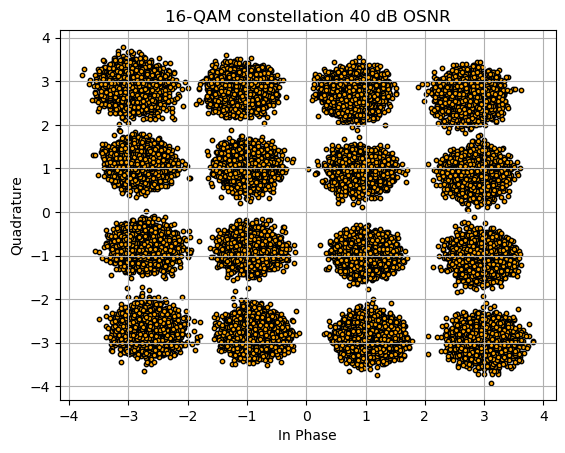

In [7]:
plt.scatter(X[-1, :,0], X[-1, :,1], s=10, color='orange', edgecolor='black')
plt.xlabel('In Phase')
plt.ylabel('Quadrature')
plt.title('16-QAM constellation 40 dB OSNR')
plt.grid()
plt.show()

### K-Means Demodulation

In [8]:
init_cent = np.array([
    [-3, 3], [-3, 1], [-3, -3], [-3, -1],
    [-1, 3], [-1, 1], [-1, -3], [-1, -1],
    [3, 3], [3, 1], [3, -3], [3, -1],
    [1, 3], [1, 1], [1, -3], [1, -1]
])

kmeans = KMeans(n_clusters=16, init=init_cent)

In [9]:
acc_kmeans = []
ber_kmeans = []
for i in range(len(OSNR)):
    kmeans.fit(X[i])
    labels = kmeans.labels_
    ber_kmeans.append(bit_error_rate(y[i], labels))
    acc_kmeans.append(accuracy_score(y[i], labels)*100)

### DBSCAN Demodulation

In [10]:
def threshold_density(labels, X, umbral=0.5):
    noise_labels = np.where(labels == -1)[0]
    for i in noise_labels:
        point = X[i]
        density = np.sum(np.linalg.norm(X - point, axis=1) <= umbral)
        if density > 1:
            distance_to_points = np.linalg.norm(X - point, axis=1)
            neighbors = np.where(distance_to_points <= umbral)[0]
            neighbors_labels = labels[neighbors]
            neighbors_labels = neighbors_labels[neighbors_labels != -1]
            if len(neighbors_labels) > 0:
                new_labels = np.bincount(neighbors_labels).argmax()
                labels[i] = new_labels
    return labels

In [11]:
dbscan = DBSCAN(eps=0.1, min_samples=50)

In [12]:
acc_dbscan = []
ber_dbscan = []
for i in range(len(OSNR)):
    df = pd.DataFrame()
    df['X'] = X[i, :, 0] + 1j*X[i, :, 1]
    df['y'] = y[i]
    df = df.sort_values(by=['y'])
    aux = np.array([np.real(df['X']), np.imag(df['X'])]).T
    dbscan.fit(aux)
    labels = dbscan.labels_
    labels = threshold_density(labels, aux, umbral=0.3)
    ber_dbscan.append(bit_error_rate(df['y'], labels))
    acc_dbscan.append(accuracy_score(df['y'], labels)*100)

### Comparsion

In [13]:
def fit_curve(x_step, x, y, deg=2):
    p = np.polyfit(x, y, deg)
    z = np.poly1d(p)
    curve = z(x_step)
    return curve

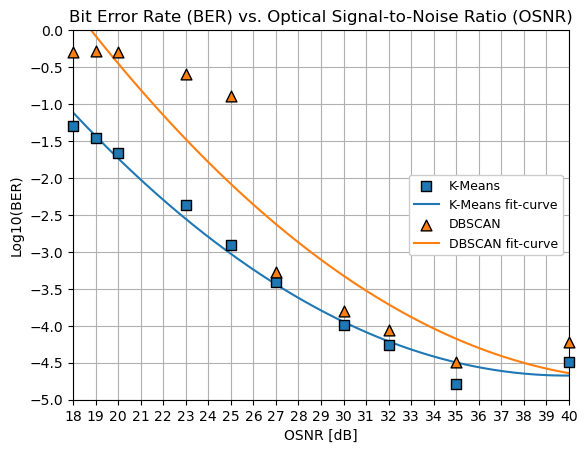

In [14]:
x_step = np.linspace(np.min(OSNR), np.max(OSNR), 1000)

plt.scatter(OSNR, np.log10(ber_kmeans), s=60, marker='s', edgecolor='k', label='K-Means', zorder=3, clip_on=False)
plt.plot(x_step, fit_curve(x_step, OSNR, np.log10(ber_kmeans)), label='K-Means fit-curve')

plt.scatter(OSNR, np.log10(ber_dbscan), s=60, marker='^', edgecolor='k', label='DBSCAN', zorder=3, clip_on=False)
plt.plot(x_step, fit_curve(x_step, OSNR, np.log10(ber_dbscan)), label='DBSCAN fit-curve')

plt.title('Bit Error Rate (BER) vs. Optical Signal-to-Noise Ratio (OSNR)')
plt.xlabel('OSNR [dB]')
plt.ylabel('Log10(BER)')
plt.xlim([np.min(OSNR), np.max(OSNR)])
plt.ylim([-5, 0])
plt.xticks(np.arange(np.min(OSNR), np.max(OSNR)+1, 1))
plt.yticks(np.arange(-5, 0.1, 0.5))
plt.legend(loc='center right', fontsize=9, framealpha=1)
plt.grid()
plt.show()

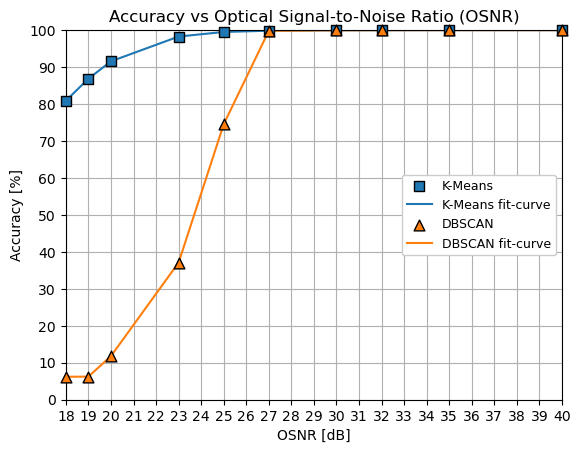

In [15]:
x_step = np.linspace(np.min(OSNR), np.max(OSNR), 1000)

plt.scatter(OSNR, acc_kmeans, s=60, marker='s', edgecolor='k', label='K-Means', zorder=3, clip_on=False)
plt.plot(OSNR, acc_kmeans, label='K-Means fit-curve')

plt.scatter(OSNR, acc_dbscan, s=60, marker='^', edgecolor='k', label='DBSCAN', zorder=3, clip_on=False)
plt.plot(OSNR, acc_dbscan, label='DBSCAN fit-curve')

plt.title('Accuracy vs Optical Signal-to-Noise Ratio (OSNR)')
plt.xlabel('OSNR [dB]')
plt.ylabel('Accuracy [%]')
plt.xlim([np.min(OSNR), np.max(OSNR)])
plt.ylim([0, 100])
plt.xticks(np.arange(np.min(OSNR), np.max(OSNR)+1, 1))
plt.yticks(np.arange(0, 101, 10))
plt.legend(loc='center right', fontsize=9, framealpha=1)
plt.grid()
plt.show()